# Práctica 3 - Prueba 11

#### Pilar Navarro Ramírez

In [1]:
import pandas as pd

## Preprocesamiento

In [2]:
df_train=pd.read_csv("data/train.csv",na_values=[""])
df_test=pd.read_csv("data/test.csv",na_values=[""])

In [3]:
df_train.columns = [col.lower() for col in df_train]
df_test.columns = [col.lower() for col in df_test]

df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

del df_train["id"]
del df_test["id"]

### Tratamos los datos perdidos

In [4]:
from sklearn import impute

In [5]:
del df_train['descuento']
del df_test['descuento']

In [6]:
df_train_replaced=df_train.copy()
imputer=impute.SimpleImputer(strategy="most_frequent")
values = imputer.fit_transform([df_train_replaced.asientos.values])
df_train_replaced.asientos.update(pd.Series(values[0]))

In [7]:
df_train_replaced=df_train_replaced.dropna()
df_train=df_train.dropna()

Separamos el atributo a predecir del resto de atributos en el conjunto de entrenamiento.

In [8]:
cols = [col for col in df_train.columns if col not in ['precio_cat']]    
df_train, df_train_obj= df_train[cols], df_train['precio_cat']
df_train_replaced, df_train_obj_replaced= df_train_replaced[cols], df_train_replaced['precio_cat']

### Nos quedamos sólo con la marca del nombre

In [9]:
nombre=pd.read_csv("data/nombre.csv")
nombre.columns = [col.lower() for col in nombre]

#Función que se queda con la primera palabra de una cadena
def marca(cad):
    return cad.split(' ', 1)[0]
nombre['nombre'] = nombre['nombre'].map(marca)
nombre=nombre.drop_duplicates()
df_train['nombre']=df_train['nombre'].map(marca)
df_train_replaced['nombre']=df_train_replaced['nombre'].map(marca)
df_test['nombre']=df_test['nombre'].map(marca)

### Normalización de los datos numéricos

In [10]:
from sklearn.preprocessing import MinMaxScaler

exc=["nombre","ciudad","combustible","tipo_marchas","mano","consumo","motor_cc","potencia",'precio_cat','id','descuento']
cols = [col for col in df_train_orig.columns if col not in exc]  


df_train_norm=df_train.copy()
df_train_norm_rpl=df_train_replaced.copy()
df_test_norm=df_test.copy()


for atributo in cols:
    data=pd.read_csv("data/"+atributo+".csv")
    data.columns = [col.lower() for col in data]
    scaler = MinMaxScaler().fit(data.values)
    train_values=df_train[atributo].values.reshape(-1,1)
    df_train_norm[atributo]=scaler.transform(train_values)
    train_values_rpl=df_train_replaced[atributo].values.reshape(-1,1)
    df_train_norm_rpl[atributo]=scaler.transform(train_values_rpl)
    test_values=df_test[atributo].values.reshape(-1,1)
    df_test_norm[atributo]=scaler.transform(test_values)
    

### 'Transformación' de variables categóricas a binarias

In [11]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

categorical=["nombre","ciudad","combustible","tipo_marchas","mano","consumo","motor_cc","potencia"]
cols = [col for col in df_train.columns if col not in categorical]    

df_train_num=df_train_norm.copy()
df_train_num_rpl=df_train_norm_rpl.copy()
df_test_num=df_test_norm.copy()

df_train_num=np.array(df_train_num[cols])
df_train_num_rpl=np.array(df_train_num_rpl[cols])
df_test_num=np.array(df_test_num[cols])

for atributo in categorical:
    if atributo=='nombre':
        data=nombre.copy()
    else:
        data=pd.read_csv("data/"+atributo+".csv")
        data.columns = [col.lower() for col in data]
    enc = OneHotEncoder().fit(data[atributo].values.reshape(-1,1))

    #Conjunto de entrenamiento con ambos preprocesamientos
    enc_train=enc.transform(df_train[atributo].values.reshape(-1,1)).toarray()        
    df_train_num=np.hstack((df_train_num,enc_train))
    
    enc_train_rpl=enc.transform(df_train_replaced[atributo].values.reshape(-1,1)).toarray()
    df_train_num_rpl=np.hstack((df_train_num_rpl,enc_train_rpl))

    
    #Conjunto de test
    enc_test=enc.transform(df_test[atributo].values.reshape(-1,1)).toarray()
    df_test_num=np.hstack((df_test_num,enc_test))
                          
df_train_num=pd.DataFrame(df_train_num)
df_train_num_rpl=pd.DataFrame(df_train_num_rpl)
df_test_num=pd.DataFrame(df_test_num)

Eliminamos las columnas que son todo nula.

In [12]:
cols = [col for col in df_train_num.columns if df_train_num[col].max()!=0.0]
df_train_num=df_train_num[cols]
df_test_num=df_test_num[cols]
df_train_num_rpl=df_train_num_rpl[cols]

### Oversampling

In [13]:
from imblearn.combine import SMOTETomek
from collections import Counter
smote=SMOTETomek(random_state=10)
df_train_over, df_train_obj_over = smote.fit_resample(df_train_num, df_train_obj)
df_train_over_rpl, df_train_obj_over_rpl = smote.fit_resample(df_train_num_rpl, df_train_obj_replaced)
Counter(df_train_obj_over)

Counter({3: 1716, 2: 1763, 4: 1752, 5: 1818, 1: 1810})

## Aplicación de los algoritmos

In [14]:
import numpy as np

from sklearn.model_selection import cross_val_score

def cross_validation(clf,x,y,mostrar=False):
    scores=cross_val_score(clf,x,y,scoring='accuracy',cv=5)
    accuracy=np.mean(scores)  
    if mostrar:
        print("Accuracy: ", accuracy)
    return accuracy

### Stacking

In [20]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

forest=RandomForestClassifier(random_state=10)
svc=LinearSVC(random_state=10,C=50,max_iter=100000)
extra=ExtraTreesClassifier(n_estimators=180,random_state=10)
NN=MLPClassifier(hidden_layer_sizes=(460,460),random_state=10,max_iter=10000,alpha=0.009)
gradient=GradientBoostingClassifier(n_estimators=100, random_state=10,max_features='auto',subsample=0.8,max_depth=19)

estimators = [('Linear SVC', svc),
     ('forest', forest),('gradient', gradient),('Red',NN)]

clf = StackingClassifier(estimators=estimators, final_estimator=forest,cv=5)
cross_validation(clf, df_train_over, df_train_obj_over,True)

Accuracy:  0.9636549729591245


0.9636549729591245

In [21]:
estimators = [('Linear SVC', svc),
     ('forest', forest),('gradient', gradient),('Red',NN)]

clf = StackingClassifier(estimators=estimators, final_estimator=gradient,cv=5)
cross_validation(clf, df_train_over, df_train_obj_over,True)

Accuracy:  0.9647835774001248


0.9647835774001248

In [22]:
estimators = [('Linear SVC', svc),
     ('forest', forest),('gradient', gradient),('Red',NN)]

clf = StackingClassifier(estimators=estimators, final_estimator=NN,cv=5)
cross_validation(clf, df_train_over, df_train_obj_over,True)

Accuracy:  0.9588016360908697


0.9588016360908697

In [23]:
estimators = [('forest', forest),('gradient', gradient),('Red',NN)]

clf = StackingClassifier(estimators=estimators, final_estimator=forest,cv=5)
cross_validation(clf, df_train_over, df_train_obj_over,True)

Accuracy:  0.9633163725076572


0.9633163725076572

In [15]:
estimators = [('gradient', gradient),('Red',NN)]

clf = StackingClassifier(estimators=estimators, final_estimator=forest,cv=5)
cross_validation(clf, df_train_over, df_train_obj_over,True)

Accuracy:  0.9620743276744846


0.9620743276744846

In [16]:
estimators = [('Linear SVC', svc),
     ('forest', forest),('gradient', gradient),('Red',NN),('extra',extra)]

clf = StackingClassifier(estimators=estimators, final_estimator=forest,cv=5)
cross_validation(clf, df_train_over, df_train_obj_over,True) 

Accuracy:  0.9646707105829689


0.9646707105829689

### Configuración de los parámetros

#### Extra Trees

Parámetro bootstrap.

In [17]:
extra=ExtraTreesClassifier(random_state=10,bootstrap=True)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9475136160335886


0.9475136160335886

In [18]:
extra=ExtraTreesClassifier(random_state=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9527057445449829


0.9527057445449829

Configuramos el número de árboles

In [19]:
from matplotlib import pyplot as plt

def tune_num_arboles(max_value):
    acc=[]
    for i in range(50,max_value,20):
        extra=ExtraTreesClassifier(n_estimators=i,random_state=10)
        print(i)
        acc.append(cross_validation(extra,df_train_over,df_train_obj_over,True))

    fig, ax =plt.subplots(figsize=(15,5))
    ax.plot(range(50,max_value,20), acc)
    ax.set_title('Extra trees')
    ax.set_xlabel('Num árboles')
    ax.set_ylabel('Accuracy')
    plt.show()

50
Accuracy:  0.9523672715546304
70
Accuracy:  0.9528188662843682
90
Accuracy:  0.9529316693709665
110
Accuracy:  0.9537216733604994
130
Accuracy:  0.9534960034567455
150
Accuracy:  0.9538345401776553
170
Accuracy:  0.95417320435968
190
Accuracy:  0.9547374109843438
210
Accuracy:  0.9546244804366308
230
Accuracy:  0.9549631446186556
250
Accuracy:  0.9554148668095082
270
Accuracy:  0.9550762663580409
290
Accuracy:  0.9551891331751966


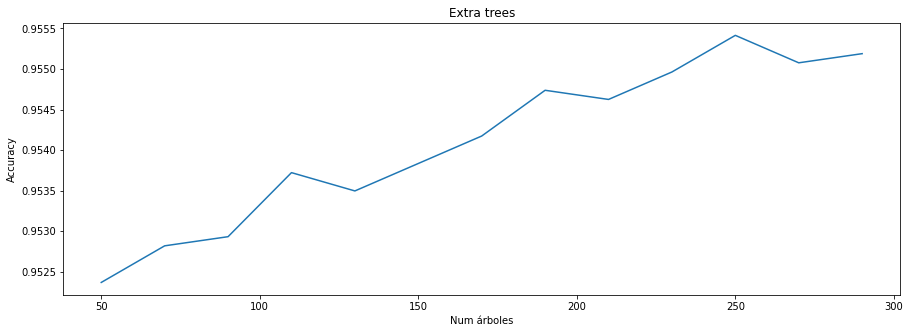

In [20]:
tune_num_arboles(300)

In [21]:
extra=ExtraTreesClassifier(n_estimators=175,random_state=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9546246078977456


0.9546246078977456

In [22]:
extra=ExtraTreesClassifier(n_estimators=180,random_state=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.955076138896926


0.955076138896926

In [23]:
extra=ExtraTreesClassifier(n_estimators=185,random_state=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9549631446186554


0.9549631446186554

In [24]:
extra=ExtraTreesClassifier(n_estimators=190,random_state=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9547374109843438


0.9547374109843438

Vemos si mejora al cambiar el parámetro max_depth:

In [25]:
extra=ExtraTreesClassifier(n_estimators=180,random_state=10,max_depth=5)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.6700560064138432


0.6700560064138432

In [26]:
extra=ExtraTreesClassifier(n_estimators=180,random_state=10,max_depth=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.7837254462094976


0.7837254462094976

In [27]:
extra=ExtraTreesClassifier(n_estimators=180,random_state=10,max_depth=20)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.8987489691582342


0.8987489691582342

In [28]:
extra=ExtraTreesClassifier(n_estimators=180,random_state=10,max_depth=80)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.9539474707253686


0.9539474707253686

Mejores resultados:

In [29]:
extra=ExtraTreesClassifier(n_estimators=180,random_state=10)
cross_validation(extra, df_train_over, df_train_obj_over,True)

Accuracy:  0.955076138896926


0.955076138896926

### Aplicación al conjunto de test

#### **Entrega 18**

In [30]:
forest=RandomForestClassifier(random_state=10)
svc=LinearSVC(random_state=10,C=50,max_iter=100000)
extra=ExtraTreesClassifier(n_estimators=180,random_state=10)
NN=MLPClassifier(hidden_layer_sizes=(460,460),random_state=10,max_iter=10000,alpha=0.009)
gradient=GradientBoostingClassifier(n_estimators=100, random_state=10,max_features='auto',subsample=0.8,max_depth=19)

estimators = [('Linear SVC', svc),
     ('forest', forest),('gradient', gradient),('Red',NN)]

clf = StackingClassifier(estimators=estimators, final_estimator=gradient,cv=5)
cross_validation(clf, df_train_over, df_train_obj_over,True)
clf.fit(df_train_over,df_train_obj_over)
pred=clf.predict(df_test_num)
ids=df_test_orig["id"]

df_result = pd.DataFrame({'id': ids, 'Precio_cat': pred})
df_result.to_csv("resultados_18.csv", index=False)

Accuracy:  0.9647835774001248


#### Entrega 19

In [31]:
estimators = [('Linear SVC', svc),
     ('forest', forest),('gradient', gradient),('Red',NN)]

clf = StackingClassifier(estimators=estimators, final_estimator=forest,cv=5)
cross_validation(clf, df_train_over, df_train_obj_over,True)
clf.fit(df_train_over,df_train_obj_over)
pred=clf.predict(df_test_num)
ids=df_test_orig["id"]

df_result = pd.DataFrame({'id': ids, 'Precio_cat': pred})
df_result.to_csv("resultados_19.csv", index=False)

Accuracy:  0.9636549729591245


#### Entrega 20

In [32]:
forest=RandomForestClassifier(random_state=10)
svc=LinearSVC(random_state=10,C=50,max_iter=100000)
extra=ExtraTreesClassifier(n_estimators=180,random_state=10)
NN=MLPClassifier(hidden_layer_sizes=(460,460),random_state=10,max_iter=10000,alpha=0.009)
gradient=GradientBoostingClassifier(n_estimators=100, random_state=10,max_features='auto',subsample=0.8,max_depth=19)
estimators = [('Linear SVC', svc),
     ('forest', forest),('gradient', gradient),('Red',NN),('extra',extra)]

clf = StackingClassifier(estimators=estimators, final_estimator=forest,cv=5)
cross_validation(clf, df_train_over, df_train_obj_over,True)
clf.fit(df_train_over,df_train_obj_over)
pred=clf.predict(df_test_num)
ids=df_test_orig["id"]

df_result = pd.DataFrame({'id': ids, 'Precio_cat': pred})
df_result.to_csv("resultados_20.csv", index=False)

Accuracy:  0.9646707105829689
